<a href="https://colab.research.google.com/github/PederRonning/sok-3023/blob/main/Copy_of_sok_3023_utkast_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
# Starter med å importere to viktig libraries for LSTM

import tensorflow as tf
import pandas as pd

# Leser csv filen
#df = pd.read_csv('NO0010791353_10.02.2025_16.23.44.csv', delimiter=';', names=['date', 'adjusted_price'])
#df = df.drop(0) # fjern første rad som hadde kolonnenavnene
#df.head()

In [66]:
%pip install --quiet pmdarima

In [67]:
# Leser csv filen
#df = pd.read_csv('/content/project/2074251_26.02.2025_08.54.35.csv', delimiter=';', names=['date', 'last'])
#df = df.drop(0) # fjern første rad som hadde kolonnenavnene
#df.head()

In [68]:
# Leser csv filen
df = pd.read_csv('OSLO Shipping Historical Data.csv')
#df = df.drop(0) # fjern første rad som hadde kolonnenavnene
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,02/26/2025,755.22,758.26,763.59,755.09,NaN,-0.39%
1,02/25/2025,758.20,770.23,776.15,758.18,NaN,-1.58%
2,02/24/2025,770.34,788.43,789.70,769.45,NaN,-1.83%
3,02/21/2025,784.68,785.68,798.64,783.19,NaN,-0.11%
4,02/20/2025,785.54,807.68,807.68,783.41,NaN,-2.64%


In [69]:
df.shape

(1298, 7)

In [70]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
1293,01/08/2020,223.10,222.60,224.40,222.03,NaN,0.24%
1294,01/07/2020,222.57,221.13,223.48,221.04,NaN,0.65%
1295,01/06/2020,221.13,225.41,226.37,219.40,NaN,-1.89%
1296,01/03/2020,225.39,220.70,225.99,220.70,NaN,2.13%
1297,01/02/2020,220.70,213.92,221.90,213.92,NaN,3.22%


In [71]:
import matplotlib.pyplot as plt
import datetime
# endre format
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y') # dataen er i amerikansk datoformat
df['Price'] = df['Price'].str.replace(',', '').astype(float)

In [72]:
df = df.sort_values(by='Date') # sorter etter dato
# fjern alle kolonner utenom pris og dato
df = df[['Date', 'Price']]

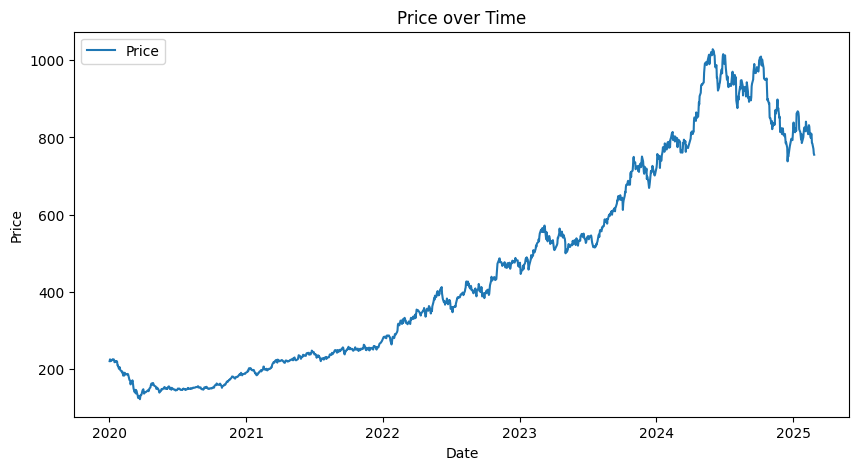

In [73]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Price'], label='Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price over Time')
plt.legend()
plt.show()

In [74]:
### Funksjon som endrer et 'Object' med splitten '-' til datetime-variabel.
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2]) # Splitter på hver int (heltall)
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2023-02-20')
type(datetime_object)

datetime.datetime

In [75]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Konverter strengdatoer til datetime
    first_date = pd.to_datetime(first_date_str)
    last_date = pd.to_datetime(last_date_str)

    # Sett 'Date' som indeks og sorter
    dataframe = dataframe.set_index('Date').sort_index()

    target_date = first_date
    dates, X, Y = [], [], []

    last_time = False

    while not last_time:
        # Hent n+1 siste rader opp til target_date
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        # Sjekk om det er nok data
        if len(df_subset) != n + 1:
            print(f"Feil: Vindu av størrelse {n} er for stort for {target_date}")
            return None

        # Hent verdiene (bruk 'Price' istedenfor 'Close')
        values = df_subset['Price'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Finn neste gyldige dato i indeksen
        try:
            current_idx = dataframe.index.get_loc(target_date)
            next_date = dataframe.index[current_idx + 1]
        except IndexError:
            break  # Ingen flere datoer

        target_date = next_date

        # Avslutt hvis vi når siste dato
        if target_date > last_date:
            last_time = True

    # Bygg resultatdataframe
    ret_df = pd.DataFrame({'Target Date': dates})
    X = np.array(X)

    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Eksempel på bruk
windowed_df = df_to_windowed_df(
    df,
    first_date_str='2020-01-10',
    last_date_str='2025-02-26',
    n=6
)
windowed_df

,Target Date,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2020-01-10,220.70,225.39,221.13,222.57,223.10,224.37,225.60
1,2020-01-13,225.39,221.13,222.57,223.10,224.37,225.60,225.23
2,2020-01-14,221.13,222.57,223.10,224.37,225.60,225.23,223.28
3,2020-01-15,222.57,223.10,224.37,225.60,225.23,223.28,218.01
4,2020-01-16,223.10,224.37,225.60,225.23,223.28,218.01,218.16
...,...,...,...,...,...,...,...,...
1287,2025-02-20,831.79,828.05,813.51,798.75,810.14,806.84,785.54
1288,2025-02-21,828.05,813.51,798.75,810.14,806.84,785.54,784.68
1289,2025-02-24,813.51,798.75,810.14,806.84,785.54,784.68,770.34
1290,2025-02-25,798.75,810.14,806.84,785.54,784.68,770.34,758.20


In [76]:
# Her konverteres winowed_df om til våre features (X) og target (y). Kilde: Gregg Hogg (YouTube)

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1292,), (1292, 6, 1), (1292,))

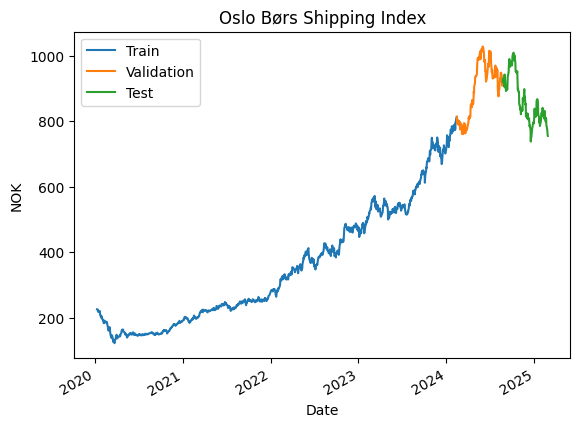

In [77]:
q_80 = int(len(dates) * .80)
q_90 = int(len(dates) * .90)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

# Formaterer x-aksen til å vise datoer og roterer dem
plt.gcf().autofmt_xdate()  # Automatisk rotasjon av datoer fordi det ser pent ut:)

# Adder labels og title
plt.xlabel('Date')
plt.ylabel('NOK')
plt.title('Oslo Børs Shipping Index')

plt.legend(['Train', 'Validation', 'Test'])

# Vis plot
plt.show()

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, callbacks=[early_stopping])

#model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 157023.0312 - mean_absolute_error: 353.6897 - val_loss: 813215.2500 - val_mean_absolute_error: 897.9355
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 148873.3125 - mean_absolute_error: 341.6626 - val_loss: 786949.0000 - val_mean_absolute_error: 883.1869
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 140499.0938 - mean_absolute_error: 325.3442 - val_loss: 642895.3750 - val_mean_absolute_error: 797.4721
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 68925.3359 - mean_absolute_error: 197.2573 - val_loss: 339764.6875 - val_mean_absolute_error: 576.9207
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 31022.9199 - mean_absolute_error: 151.4198 - val_loss: 295644.7188 - val_mean_absolute_error: 537.4266
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 24880.6445 - mean_absolute_error: 126.6881 - val_loss: 192625.4531 - val_mean_absolute_error: 431.0494
Epoch 7/500
33/33 ━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


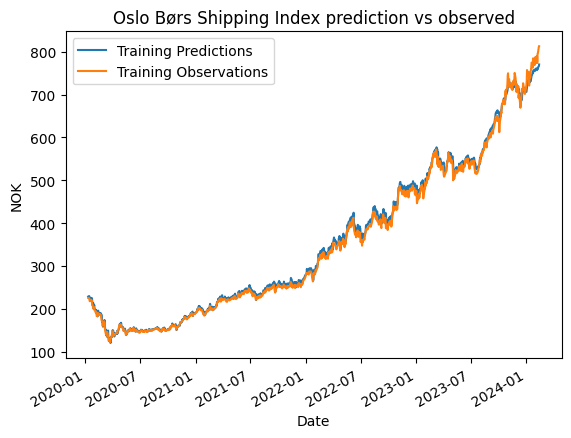

In [79]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

# Formaterer x-aksen
plt.gcf().autofmt_xdate() # auto roter

# labels og title
plt.xlabel('Date')
plt.ylabel('NOK')
plt.title('Oslo Børs Shipping Index prediction vs observed')

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


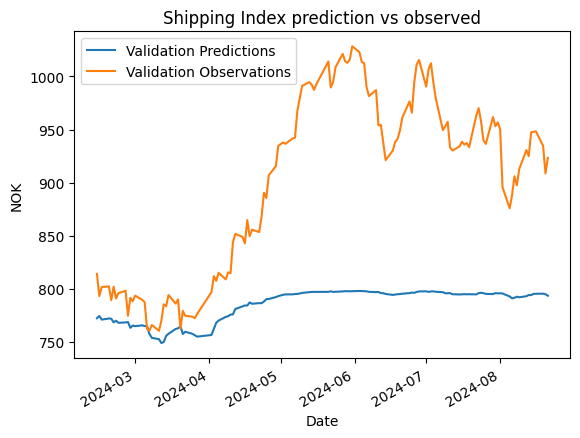

In [80]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

# Formaterer x-aksen til å vise datoer og roterer dem
plt.gcf().autofmt_xdate()  # Automatisk rotasjon av datoer fordi det ser pent ut:)


# Adder labels og title
plt.xlabel('Date')
plt.ylabel('NOK')
plt.title('Shipping Index prediction vs observed')

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


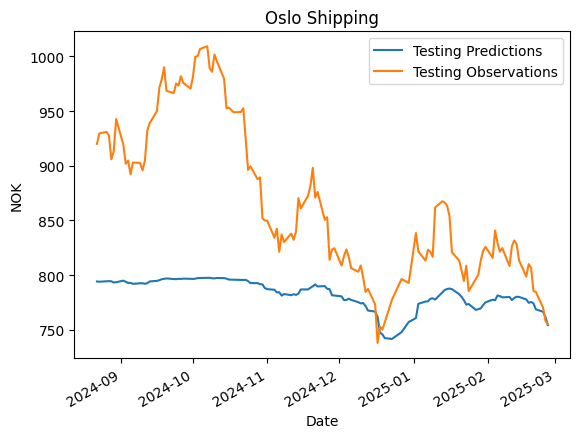

In [81]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

# Formater
plt.gcf().autofmt_xdate()

# Adder labels og title
plt.xlabel('Date')
plt.ylabel('NOK')
plt.title('Oslo Shipping')

# Vis plot
plt.show()

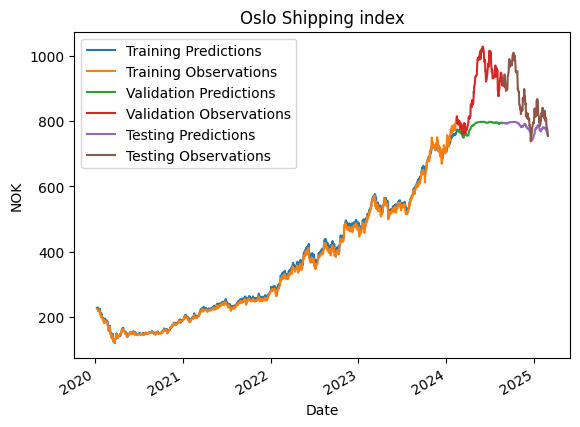

In [82]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

# Format
plt.gcf().autofmt_xdate()

# Adder labels og title
plt.xlabel('Date')
plt.ylabel('NOK')
plt.title('Oslo Shipping index')

plt.show()

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, test_predictions)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R-squared (R²)
r2 = r2_score(y_test, test_predictions)

# Outputs
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 84.5044
Mean Squared Error (MSE): 10712.5400
Root Mean Squared Error (RMSE): 103.5014
R-squared (R²): -1.1351


Bivariate S-ARIMAX model

In [84]:
# --- NEW CODE CELL -----------------------------------------------------------
oil = pd.read_csv("Crude Oil WTI Futures Historical Data.csv")

# Parse US-style date
oil["Date"] = pd.to_datetime(oil["Date"], format="%m/%d/%Y")

# Use same column name for price to keep code generic
oil["OilPrice"] = (oil["Price"]
                   .astype(str)
                   .str.replace(",", "", regex=False)
                   .astype(float))

oil = oil[["Date", "OilPrice"]].sort_values("Date")
oil.head()

,Date,OilPrice
1389,2020-01-08,59.46
1388,2020-01-09,59.44
1387,2020-01-10,58.99
1386,2020-01-13,58.08
1385,2020-01-14,58.26


In [85]:

from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the original data
result = adfuller(oil['OilPrice'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# If the p-value is greater than 0.05, the time series is non-stationary
if result[1] > 0.05:
    # Calculate first differences
    oil['OilPrice_diff'] = oil['OilPrice'].diff().dropna()

    # Ensure all values are finite:
    oil = oil[np.isfinite(oil['OilPrice_diff'])]

    # Perform the ADF test on the first differences
    result_diff = adfuller(oil['OilPrice_diff'])
    print('\nADF Statistic (first differences): %f' % result_diff[0])
    print('p-value (first differences): %f' % result_diff[1])
    print('Critical Values (first differences):')
    for key, value in result_diff[4].items():
        print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.426237
p-value: 0.569635
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568

ADF Statistic (first differences): -15.447071
p-value (first differences): 0.000000
Critical Values (first differences):
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [86]:
# Perform the ADF test on the original data
result = adfuller(df['Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# If the p-value is greater than 0.05, the time series is non-stationary
if result[1] > 0.05:
    # Calculate first differences
    df['dfPrice_diff'] = df['Price'].diff().dropna()

    # Ensure all values are finite:
    df = df[np.isfinite(df['dfPrice_diff'])]

    # Perform the ADF test on the first differences
    df_result_diff = adfuller(df['dfPrice_diff'])
    print('\nADF Statistic (first differences): %f' % df_result_diff[0])
    print('p-value (first differences): %f' % df_result_diff[1])
    print('Critical Values (first differences):')
    for key, value in df_result_diff[4].items():
        print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.393830
p-value: 0.911124
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568

ADF Statistic (first differences): -37.293795
p-value (first differences): 0.000000
Critical Values (first differences):
	1%: -3.435
	5%: -2.864
	10%: -2.568


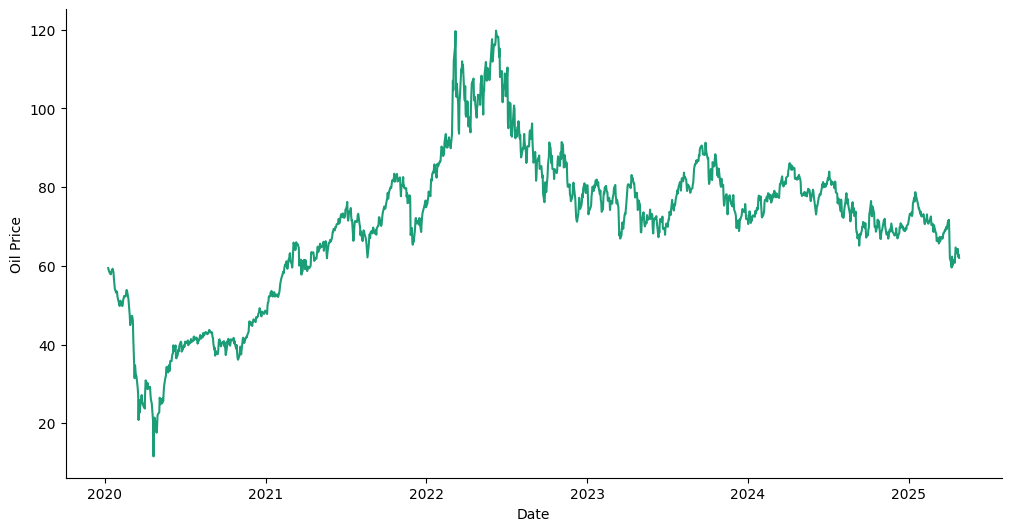

In [87]:
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['OilPrice']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = oil.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Oil Price')

In [88]:
#OLS, shipping index and oil price

import statsmodels.api as sm

# 1) Riktig opprydding og datatyper ------------------------------------
df  = pd.read_csv("OSLO Shipping Historical Data.csv")
oil = pd.read_csv("Crude Oil WTI Futures Historical Data.csv")



for d in (df, oil):
    d["Date"]  = pd.to_datetime(d["Date"], format="%m/%d/%Y")
    d["Price"] = d["Price"].astype(str).str.replace(",", "", regex=False).astype(float)

df  = df[["Date", "Price"]].rename(columns={"Price": "ShipPrice"})
oil = oil[["Date", "Price"]].rename(columns={"Price": "OilPrice"})


# 2) Synkroniser på dato -------------------------------------------------
merged = df.merge(oil, on="Date", how="inner").sort_values("Date")

# 3) Sett opp OLS -------------------------------------------------------
X = sm.add_constant(merged["OilPrice"])   # β₀-kolonnen + Oil
y = merged["ShipPrice"]                   # endogen

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              ShipPrice   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     275.8
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           2.88e-56
Time:                        08:20:39   Log-Likelihood:                -8932.8
No. Observations:                1291   AIC:                         1.787e+04
Df Residuals:                    1289   BIC:                         1.788e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.8641     26.557      1.200      0.2

In [89]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

# anta merged['Date'] er datetime64[ns]
y   = merged.set_index("Date")["ShipPrice"]
exo = merged.set_index("Date")["OilPrice"]

# la pandas forsøke å inferere frekvensen
y   = y.asfreq("B")          # 'B' = business day  (eller 'D' for kalenderdag)
exo = exo.asfreq("B")

# ev. forward-fill hull som dukker opp etter .asfreq(...)
y   = y.ffill()
exo = exo.ffill()

model = sm.tsa.statespace.SARIMAX(
    y,
    exog=exo,
    order=(1,1,1),
    seasonal_order=(1,0,1,5)
).fit()

print(model.summary())

# nå kan du generere forecast:
fc = model.get_forecast(steps=10, exog=exo[-10:])   # 10 fremtidige 'B'-dager

                                     SARIMAX Results                                     
Dep. Variable:                         ShipPrice   No. Observations:                 1341
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood               -4761.353
Date:                           Tue, 29 Apr 2025   AIC                           9534.706
Time:                                   08:21:11   BIC                           9565.908
Sample:                               01-08-2020   HQIC                          9546.395
                                    - 02-26-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
OilPrice       0.7399      0.115      6.423      0.000       0.514       0.966
ar.L1         -0.4871      0.246     -1.980

<ipython-input-92-cd3a00c07145>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exo_train = exo.loc[:train_end].replace([np.inf, -np.inf], np.nan).fillna(method='ffill')


                                     SARIMAX Results                                     
Dep. Variable:                         ShipPrice   No. Observations:                 1038
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood               -3302.584
Date:                           Tue, 29 Apr 2025   AIC                           6617.168
Time:                                   08:28:34   BIC                           6646.832
Sample:                               01-08-2020   HQIC                          6628.422
                                    - 12-29-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
OilPrice       0.5389      0.069      7.843      0.000       0.404       0.674
ar.L1         -0.9802      0.016    -59.411

<ipython-input-92-cd3a00c07145>:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exo_forecast = exo.loc[forecast_start:].replace([np.inf, -np.inf], np.nan).fillna(method='ffill')


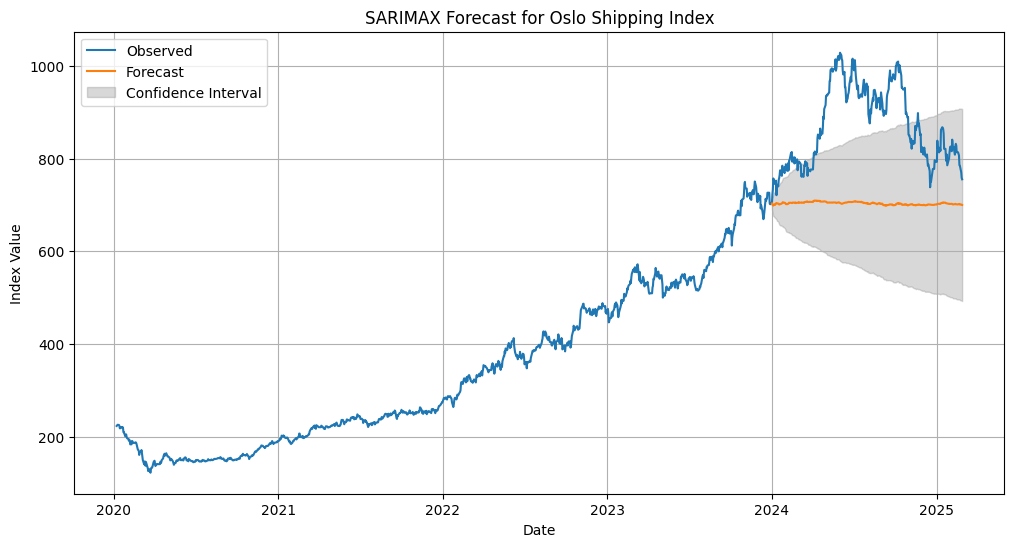

In [92]:
# 1) Tren SARIMAX på hele 2020-2023
train_end = "2023-12-29"  # Changed to the last business day in 2023

# Replace infinite or NaN values in exo for the training period
exo_train = exo.loc[:train_end].replace([np.inf, -np.inf], np.nan).fillna(method='ffill')

model = sm.tsa.statespace.SARIMAX(
    y.loc[:train_end],
    exog=exo_train,
    order=(1, 1, 1),
    seasonal_order=(1, 0, 1, 5)
).fit()

print(model.summary())

# 2) Generer prediksjoner for 2024 og utover
forecast_start = "2024-01-01"
forecast_end = y.index[-1]  # Forecast until the end of the available data

# Replace infinite or NaN values in exo for the forecast period
exo_forecast = exo.loc[forecast_start:].replace([np.inf, -np.inf], np.nan).fillna(method='ffill')

# Get forecast
fc = model.get_forecast(
    steps=len(y.loc[forecast_start:]),
    exog=exo_forecast
)

# 3) Plott prediksjonene sammen med faktiske verdier
plt.figure(figsize=(12, 6))
plt.plot(y, label="Observed")
plt.plot(fc.predicted_mean, label="Forecast")
plt.fill_between(fc.conf_int().index,
                 fc.conf_int().iloc[:, 0],
                 fc.conf_int().iloc[:, 1],
                 color='gray', alpha=0.3, label="Confidence Interval")
plt.title("SARIMAX Forecast for Oslo Shipping Index")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.grid(True)
plt.show()

In [90]:
exo

,OilPrice
Date,
2020-01-08,59.46
2020-01-09,59.44
2020-01-10,58.99
2020-01-13,58.08
2020-01-14,58.26
...,...
2025-02-20,72.57
2025-02-21,70.40
2025-02-24,70.70
